In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geoplot.crs as gcrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from ipywidgets import *

%matplotlib notebook
%matplotlib notebook

path = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(path)

def gpointplot_map(gdf, vmin=None, vmax=None, title="", variable="Particles counter"):
    """
    Generate a Geoplot Pointplot (see: https://residentmario.github.io/geoplot/pointplot.html#geoplot.pointplot)
    :param gdf: Geopandas dataframe. Must contain a geometry column (see: https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#from-longitudes-and-latitudes)
    :param vmin: Min value used to set the legend or colorbar
    :param vmax: Max value used to set the legend or colorbar
    :param title: Plot title
    """
    
    # Set figure, axes and projection
    fig = plt.figure(figsize=(800 / 96, 600 / 96), dpi=96)
    ax = plt.axes(projection=gcrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='lightgray', alpha=0.8, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Plot using geoplot
    ax = gplt.pointplot(gdf, ax=ax, hue=variable, cmap="plasma", s=20, alpha=0.9, linewidths=0, 
                        vmin=vmin, vmax=vmax, edgecolors=None, legend=True, k=None)
    
    # Setting plot atributes
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(cartopy.feature.LAKES)
    ax.add_feature(cartopy.feature.BORDERS)
    
    plt.title(title)
    
def gkdeplot_map(gdf, vmin=None, vmax=None, title=""):
    """
    Generate a Geoplot Pointplot (see: https://residentmario.github.io/geoplot/pointplot.html#geoplot.pointplot)
    :param gdf: Geopandas dataframe. Must contain a geometry column (see: https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#from-longitudes-and-latitudes)
    :param vmin: Min value used to set the legend or colorbar
    :param vmax: Max value used to set the legend or colorbar
    :param title: Plot title
    """
    
    # Set figure, axes and projection
    fig = plt.figure(figsize=(800 / 96, 600 / 96), dpi=96)
    ax = plt.axes(projection=gcrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.8, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Plot using geoplot
    ax = gplt.kdeplot(gdf, ax=ax, cmap="plasma", cbar=True)
    
    # Setting plot atributes
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(cartopy.feature.LAKES)
    ax.add_feature(cartopy.feature.BORDERS)
    
    plt.title(title)

def ggridify_map(gdf, vmin=None, vmax=None, title="", variable="Particles counter", size=5, method=np.mean, get_max=True):
    """
    Generate a Geoplot Pointplot (see: https://residentmario.github.io/geoplot/pointplot.html#geoplot.pointplot)
    :param gdf: Geopandas dataframe. Must contain a geometry column (see: https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#from-longitudes-and-latitudes)
    :param vmin: Min value used to set the legend or colorbar
    :param vmax: Max value used to set the legend or colorbar
    :param title: Plot title
    """
    
    # Set figure, axes and projection
    fig = plt.figure(figsize=(800 / 96, 600 / 96), dpi=96)
    ax = plt.axes(projection=gcrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='lightgray', alpha=0.7, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Build a grid and agregate data
    grid = glt.gridify_data(gdf, size, variable, method=method, cut=False)
    # Plot using geoplot
    ax = gplt.choropleth(grid, ax=ax, hue=variable, vmin=vmin, vmax=vmax, cmap="plasma", alpha=0.9, linewidth=0, k=None, legend=True)
    
    # Setting plot atributes
    ax.set_global()
    ax.coastlines()
    #ax.add_feature(cartopy.feature.LAND)
    #ax.add_feature(cartopy.feature.OCEAN)
    #ax.add_feature(cartopy.feature.RIVERS)
    #ax.add_feature(cartopy.feature.LAKES)
    ax.add_feature(cartopy.feature.BORDERS)
    
    plt.title(title)
    
    if get_max:
        pmax = grid.loc[grid["Particles counter"].idxmax(),:]
        c = gpd.GeoDataFrame(pmax).T
        c["centroid"] = c.centroid
        c = c.set_geometry("centroid")
        c.plot(ax=ax, marker="*", markersize=100.0, color="green", alpha=1)
        return pmax

# SUCHAI-1 Langmuir probe's particles counter analysis

## Read datafile
We are using **Pandas** and **Geopandas** to process the datafiles. Please refer to the [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/10min.html) for more details about how to use this library.

In [2]:
# Read datafile
df = pd.read_csv("../langmuir-2018-2.csv", delimiter='\t')

# Set datetime as index
df["time"] = pd.DatetimeIndex(df.time)
df.set_index("time", inplace=True)
#df.describe()

# Convert to GeoPandas using Lon and Lat columns
gdf = df.assign(Coord=list(zip(df.Lon, df.Lat)))
gdf.loc[:,"Coord"] = gdf["Coord"].apply(Point)
gdf = gpd.GeoDataFrame(gdf, geometry='Coord')

vmin = gdf["Particles counter"].min()
vmax = gdf["Particles counter"].max()

gdf.describe()

,Unnamed: 0,Particles counter,Plasma temperature,Plasma voltage,Sweep voltage,Unnamed: 0.1,Lon,Lat,Plasma current,Electron density 300K,Electron density 3000K,day,is_anom,anom_diff,group,SEASON
count,26725.000000,26725.000000,26725.000000,26725.000000,26725.000000,10194.000000,26725.000000,26725.000000,2.672500e+04,2.672500e+04,2.672500e+04,26725.000000,26725.000000,26725.000000,26725.000000,26725.000000
mean,13362.000000,62.458148,298.277717,8.249585,15.252574,194.498823,20.180359,0.783191,inf,inf,inf,0.537624,0.029111,0.000037,2.202732,1.839439
std,7714.987308,278.669461,35.816941,53.470281,95.148998,119.233925,101.661754,50.985838,NaN,NaN,NaN,0.498592,0.168122,0.106831,14.755128,0.575469
min,0.000000,0.000000,185.725000,0.000000,3.944212,4.000000,-179.999896,-82.597286,4.164574e-50,3.337337e-32,1.055359e-32,0.000000,0.000000,-1.000000,0.000000,1.000000
25%,6681.000000,1.000000,291.295000,1.739950,4.002862,95.000000,-58.130285,-44.417588,3.040061e-09,2.436193e+09,7.703920e+08,0.000000,0.000000,0.000000,0.000000,1.000000
50%,13362.000000,5.000000,294.227500,2.306900,4.012638,186.000000,2.973981,1.434168,1.562113e-08,1.251820e+10,3.958602e+09,1.000000,0.000000,0.000000,0.000000,2.000000
75%,20043.000000,10.000000,296.671250,2.702788,4.017525,283.000000,118.704275,46.106389,4.804658e-08,3.850277e+10,1.217564e+10,1.000000,0.000000,0.000000,0.000000,2.000000
max,26724.000000,3371.000000,611.000000,624.000000,824.000000,561.000000,179.989350,82.597280,inf,inf,inf,1.000000,1.000000,1.000000,153.000000,3.000000


## Point plot
We can apply some filters using the columns of the Geopandas Dataframe, ex
- "Particles counter">50: to filter by value
- "day"==1: to filter by day or nigth

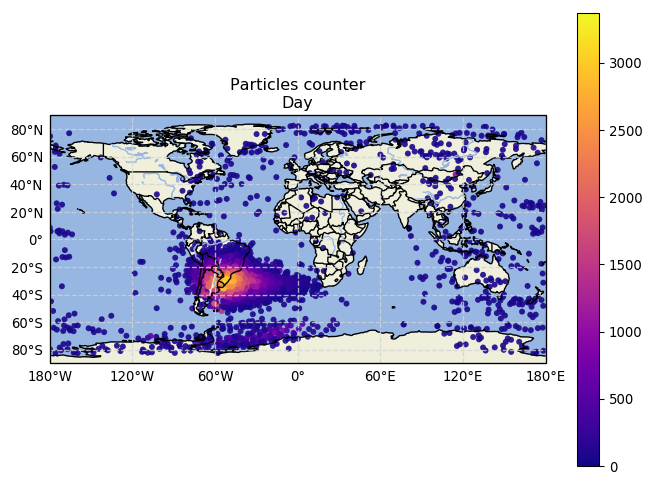

In [3]:
# Filter by value
gdf_f = gdf[gdf["Particles counter"] > 50]
# Filter by day or night using the "day" column (1=day, 0=nigth)
gdf_f = gdf_f[gdf_f["day"]==1]

#gdf = gpd.GeoDataFrame(df_f, geometry='Coord')
gpointplot_map(gdf_f, vmin=vmin, vmax=vmax, title="Particles counter\nDay")

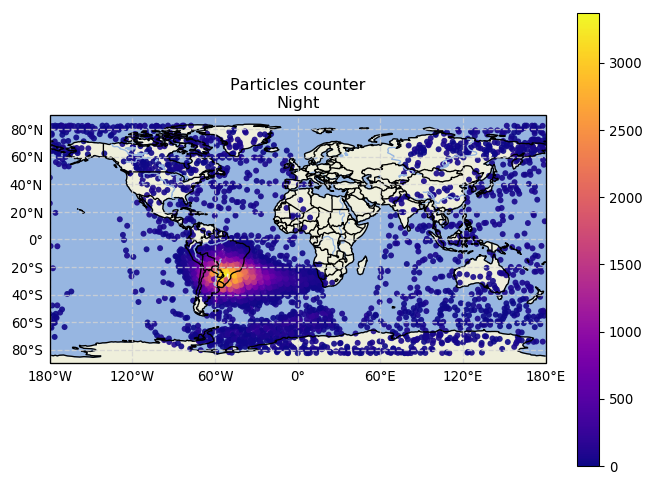

In [4]:
# Filter by value

gdf_f = gdf[gdf["Particles counter"] > 10]
#gdf_f = gdf_f["2018-07-1":"2018-07-15"]
# Filter by day or night using the "day" column (1=day, 0=nigth)
gdf_f = gdf_f[gdf_f["day"]==0]

#gdf = gpd.GeoDataFrame(df_f, geometry='Coord')
gpointplot_map(gdf_f, vmin=vmin, vmax=vmax, title="Particles counter\nNight")

### An interactive map
Move the slider to filter by value

In [6]:
def update_map(Treshold=100):
    gpointplot_map(gdf[gdf["Particles counter"] > Treshold], vmin=vmin, vmax=vmax, title="Particles counter (>{0})".format(Treshold))
    
interact(update_map, Treshold=IntSlider(value=100, min=vmin, max=vmax, step=1, continuous_update=False))

interactive(children=(IntSlider(value=100, continuous_update=False, description='Treshold', max=3371), Output(…

<function __main__.update_map(Treshold=100)>

In [7]:
def update_map(date_init="2018-01-01", date_final="2018-12-01"):
    gpointplot_map(gdf[date_init:date_final], vmin, vmax, title="SUCHAI Particles counter\n{} to {}".format(date_init, date_final))

interact(update_map, date_init=Text(value="2018-01-01" ,continuous_update=False), date_final=Text(value="2018-12-01" ,continuous_update=False))

interactive(children=(Text(value='2018-01-01', continuous_update=False, description='date_init'), Text(value='…

<function __main__.update_map(date_init='2018-01-01', date_final='2018-12-01')>

In [11]:
#df1 = df[df["Particles counter"] > 100]
#df2 = pd.DataFrame(np.zeros((df1["Particles counter"].sum()//100, df1.shape[1]))*np.nan, columns=df1.columns)

#i = 0
#print(len(df1))
#locs = []
#rps = []
#for r in df1.iterrows():
#    repeat = r[1]["Particles counter"]//100
#    df2.loc[i, :] = r[1]
#    i += repeat
#    locs.append(i)
#    rps.append(repeat)
#df2 = df2.fillna(method="ffill")

In [12]:
#df2_f = df2.assign(Coord=list(zip(df2.Lon, df2.Lat)))
#df2_f.loc[:,"Coord"] = df2_f["Coord"].apply(Point)
#gdf = gpd.GeoDataFrame(df2_f, geometry='Coord')
#gkdeplot_map(gdf, title="Particles counter")

## Gridify data
Agreggate point values in a grid using mean

**WARNING: YOU NEED TO INSTALL THE GPD_LITE_TOOLBOX FROM:** (https://github.com/mthh/gpd_lite_toolbox)[This link]

**NOTE:** ```size=n``` is the size of the grid

In [8]:
import gpd_lite_toolbox as glt
import numpy as np

#gdf.loc[:, "Particles counter"] = gdf["Particles counter"].apply(np.log)

### Day values

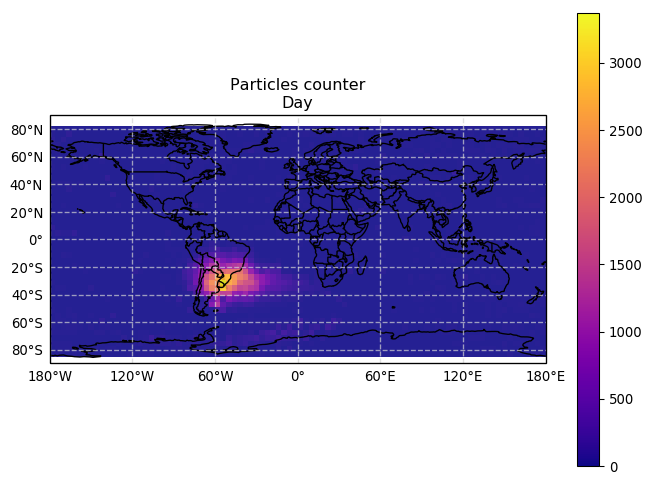

In [13]:
gdf_f = gdf[gdf["day"]==1]
pmax = ggridify_map(gdf_f, size=4, vmin=vmin, vmax=vmax, title="Particles counter\nDay", get_max=True)

In [14]:
print(pmax.geometry.centroid)
print(pmax["Particles counter"])

POINT (-53.9998957259296 -31.40272727271091)
3219.0


### Nigth values

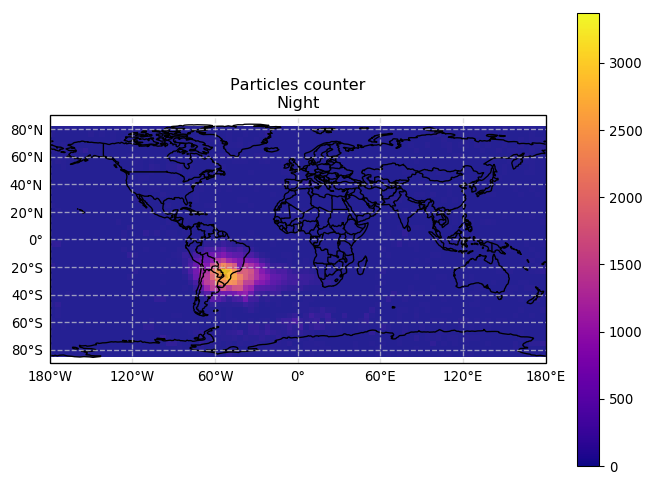

In [15]:
gdf_f = gdf[gdf["day"]==0]
pmax = ggridify_map(gdf_f, size=4, vmin=vmin, vmax=vmax, title="Particles counter\nNight", get_max=True)

In [16]:
print(pmax.geometry.centroid)
print(pmax["Particles counter"])

POINT (-53.90921813450851 -23.40272044252174)
2958.3333333333335


### Filter by date, date or night

interactive(children=(Text(value='2018-01-01', continuous_update=False, description='date_init'), Text(value='…

<function __main__.update_map(date_init='2018-01-01', date_final='2018-12-01', Filter='all')>

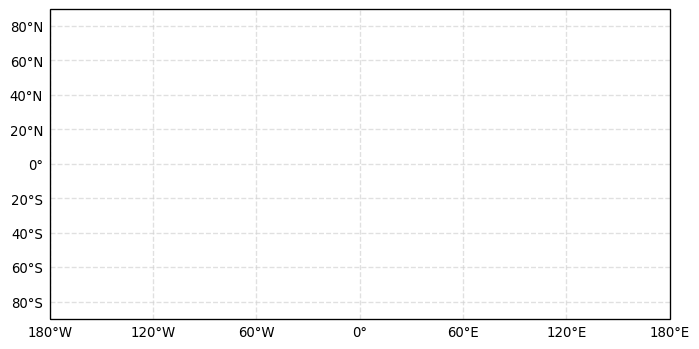

In [21]:
def update_map(date_init="2018-01-01", date_final="2018-12-01", Filter="all"):
    gdf_f = gdf[date_init:date_final]
    if Filter == "day":
        gdf_f = gdf_f[gdf_f["day"]==1]
    if Filter == "night":
        gdf_f = gdf_f[gdf_f["day"]==0]
    pmax = ggridify_map(gdf_f, size=5, vmin=vmin, vmax=vmax, title="Particles counter\n{}\n{} to {}".format(Filter, date_init, date_final))
    print("Max point", pmax["geometry"].centroid)
    print("Max value", pmax["Particles counter"])

interact(update_map, date_init=Text(value="2018-01-01" ,continuous_update=False), date_final=Text(value="2018-12-01" ,continuous_update=False), Filter=["day", "night", "all"])

### Log scale

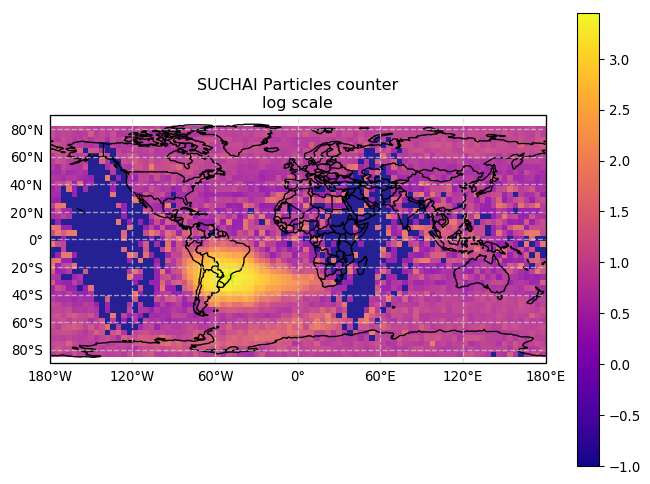

In [22]:
gdf_f = gdf[:]
gdf_f.loc[:,"Particles counter"] = gdf_f["Particles counter"].apply(np.log10)
pmax = ggridify_map(gdf_f[gdf_f["Particles counter"]>0], size=4, title="SUCHAI Particles counter\nlog scale")

In [23]:
str(pmax["geometry"].centroid)

'POINT (-49.9998957259296 -27.40272044252174)'

### An interactive plot to filter by dates

In [24]:
def update_map(date_init="2018-01-01", date_final="2018-12-01", Filter="all"):
    gdf_f = gdf[date_init:date_final]
    gdf_f.loc[:,"Particles counter"] = gdf_f["Particles counter"].apply(np.log10)
    if Filter == "day":
        gdf_f = gdf_f[gdf_f["day"]==1]
    if Filter == "night":
        gdf_f = gdf_f[gdf_f["day"]==0]
    pmax = ggridify_map(gdf_f[gdf_f["Particles counter"]>0], size=5, title="Particles counter (log scale)\n{}\n{} to {}".format(Filter, date_init, date_final))
    print(pmax["geometry"].centroid)

interact(update_map, date_init=Text(value="2018-01-01" ,continuous_update=False), date_final=Text(value="2018-12-01" ,continuous_update=False), Filter=["day", "night", "all"])

interactive(children=(Text(value='2018-01-01', continuous_update=False, description='date_init'), Text(value='…

<function __main__.update_map(date_init='2018-01-01', date_final='2018-12-01', Filter='all')>